In [1]:
!pip install category_encoders

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/content/Casestudy_Data.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56.0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57.0,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37.0,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,NaN,-36.4,4.857,5191.0,no
3,40.0,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56.0,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,NaN,-36.4,4.857,5191.0,no


In [4]:
# Function to perform mean imputation
def impute_with_mean(data, columns):
    for column in columns:
        mean = data[column].mean()
        data[column] = data[column].fillna(mean)
    return data

columns_to_fill = ['age', 'cons.price.idx']
data = impute_with_mean(data, columns_to_fill)

In [5]:
# Function for train test split
from sklearn.model_selection import train_test_split

def split_data(data, test_size=0.2, random_state=42):
    X = data.drop(columns='y')
    y = data['y'].map({'yes': 1, 'no': 0})
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                        stratify=y,
                                                        random_state=random_state)
    return X_train, X_test, y_train, y_test

In [6]:
# Function for categorical encoding
from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder

def ordinal_encoding(X_train, X_test, ordinal_features):
    le = LabelEncoder()

    for col in ordinal_features:
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])

    return X_train, X_test

def nominal_encoding(X_train, X_test, nominal_features):
    encoder_binary = BinaryEncoder(cols=nominal_features, return_df=True)

    X_train_encoded = encoder_binary.fit_transform(X_train)
    X_test_encoded = encoder_binary.transform(X_test)

    return X_train_encoded, X_test_encoded

In [7]:
# Function to fit model and get eval metrics
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

def train_and_evaluate(X_train, X_test, y_train, y_test):
    eval_metrics = dict()

    model = XGBClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
    eval_metrics['Overall Accuracy'] = accuracy_score(y_test, y_pred)
    eval_metrics['Precision Class 0'] = precision[0]
    eval_metrics['Recall Class 0'] = recall[0]
    eval_metrics['Precision Class 1'] = precision[1]
    eval_metrics['Recall Class 1'] = recall[1]
    eval_metrics['F1 Score Class 0'] = f1[0]
    eval_metrics['F1 Score Class 1'] = f1[1]
    eval_metrics['AUC score'] = roc_auc_score(y_test, y_pred)

    return eval_metrics

In [8]:
# Function for end to end implementation and get eval metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
def ml_pipeline(data, ordinal_features, nominal_features):
  eval_metrics = dict()

  # Train Test Split
  X_train, X_test, y_train, y_test = split_data(data)

  # Categorical Encoding
  X_train_encoded, X_test_encoded = ordinal_encoding(X_train, X_test, ordinal_features)
  X_train_encoded, X_test_encoded = nominal_encoding(X_train_encoded, X_test_encoded, nominal_features)

  # Modeling
  eval_metrics = train_and_evaluate(X_train_encoded, X_test_encoded, y_train, y_test)

  return eval_metrics

# Base Line Metrics

In [43]:
nominal_features = ['marital', 'default', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
ordinal_features = ['job', 'education', 'housing']

In [10]:
blm_metrics = ml_pipeline(data, ordinal_features, nominal_features)

In [16]:
blm_metrics_df = pd.DataFrame(blm_metrics, index=['blm_metrics'])
blm_metrics_df

,Overall Accuracy,Precision Class 0,Recall Class 0,Precision Class 1,Recall Class 1,F1 Score Class 0,F1 Score Class 1,AUC score
blm_metrics,0.917698,0.944981,0.963338,0.659033,0.55819,0.954071,0.604434,0.760764


# Feature Engineering 01: PCA

In [17]:
from sklearn.decomposition import PCA
import numpy as np

def apply_pca(X_train, X_test, desired_variance=0.95):
    pca = PCA()
    pca.fit(X_train)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    num_components = np.argmax(cumulative_variance >= desired_variance) + 1

    pca = PCA(n_components=num_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    return X_train_pca, X_test_pca

In [19]:
X_train, X_test, y_train, y_test = split_data(data)
X_train_encoded, X_test_encoded = ordinal_encoding(X_train, X_test, ordinal_features)
X_train_encoded, X_test_encoded = nominal_encoding(X_train_encoded, X_test_encoded, nominal_features)

X_train_pca, X_test_pca = apply_pca(X_train_encoded, X_test_encoded)

pca_metrics = train_and_evaluate(X_train_pca, X_test_pca, y_train, y_test)

In [20]:
fe_1_metrics_df = pd.DataFrame(blm_metrics, index=['fe1_metrics'])
fe_1_metrics_df

,Overall Accuracy,Precision Class 0,Recall Class 0,Precision Class 1,Recall Class 1,F1 Score Class 0,F1 Score Class 1,AUC score
pca_metrics,0.917698,0.944981,0.963338,0.659033,0.55819,0.954071,0.604434,0.760764


Note:

1. PCA did not improve the performance
2. PCA assumes normal distribution of data

# Feature Engineering 02: Deleting features using correlation matrix

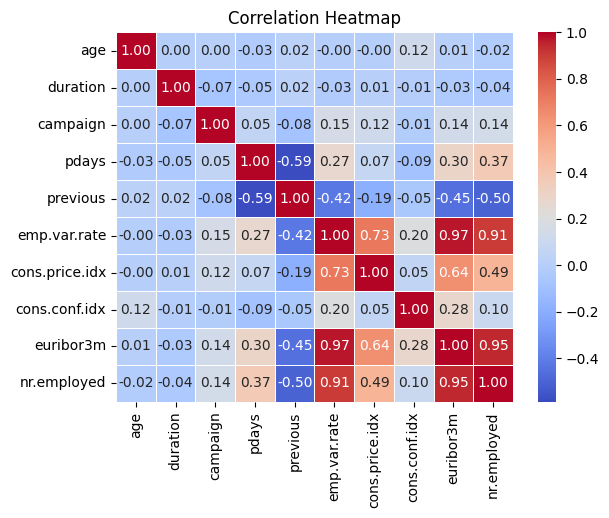

In [21]:
import seaborn as sns

def plot_correlation_heatmap(data):
    corr_matrix = data.corr()

    plt.figure(figsize=(6.4, 4.8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()

plot_correlation_heatmap(data)

In [22]:
def drop_highly_correlated_columns(data, threshold=0.69):
    data = data.copy()
    dropped_columns = []
    corr_matrix = data.corr()

    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname_i = corr_matrix.columns[i]
                colname_j = corr_matrix.columns[j]

                if corr_matrix[colname_i].mean() > corr_matrix[colname_j].mean():
                    data.drop(colname_i, axis=1, inplace=True, errors='ignore')
                    dropped_columns.append(colname_i)
                else:
                    data.drop(colname_j, axis=1, inplace=True, errors='ignore')
                    dropped_columns.append(colname_j)

    return dropped_columns, data

dropped_columns, engineered_data = drop_highly_correlated_columns(data)
dropped_columns

['emp.var.rate', 'euribor3m', 'emp.var.rate', 'euribor3m']

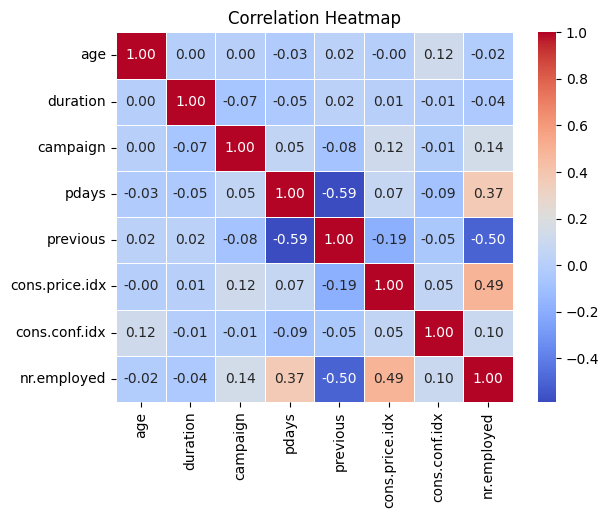

In [23]:
plot_correlation_heatmap(engineered_data)

In [25]:
fe2_metrics = ml_pipeline(engineered_data, ordinal_features, nominal_features)

In [26]:
fe_2_metrics_df = pd.DataFrame(blm_metrics, index=['fe2_metrics'])
fe_2_metrics_df

,Overall Accuracy,Precision Class 0,Recall Class 0,Precision Class 1,Recall Class 1,F1 Score Class 0,F1 Score Class 1,AUC score
pca_metrics,0.917698,0.944981,0.963338,0.659033,0.55819,0.954071,0.604434,0.760764


Note: Does not perform better than Baseline performance

# Feature Engineering 3: Checking for highly correlated feature with target and deleting

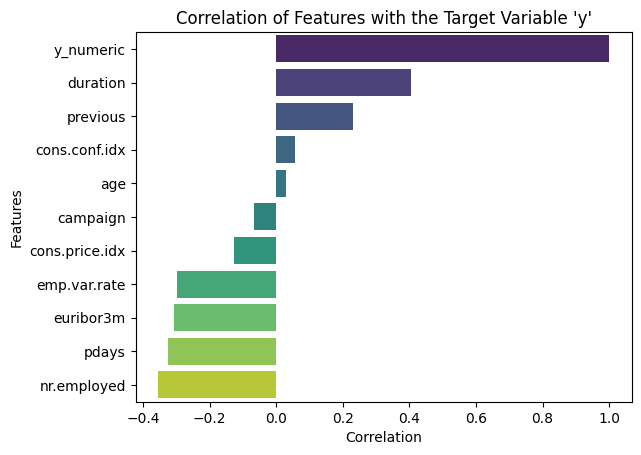

In [19]:
# Check correlation of variables with target variable
def visualize_correlation_with_target(data):
    data_copy = data.copy()
    data_copy['y_numeric'] = data_copy['y'].map({'yes': 1, 'no': 0})
    correlation_with_target = data_copy.corr()['y_numeric'].sort_values(ascending=False)

    # Plot correlation values
    plt.figure(figsize=(6.4, 4.8))
    sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, palette='viridis')
    plt.title("Correlation of Features with the Target Variable 'y'")
    plt.xlabel("Correlation")
    plt.ylabel("Features")
    plt.show()

visualize_correlation_with_target(data)

Note: There is no feature is highly correlated with target variable

# Feature Engineering 4: Removing Feature with constant values

In [20]:
# Check if data has any constant columns
def find_constant_columns(data):
    constant_columns = [col for col in data.columns if data[col].nunique() == 1]

    if constant_columns:
        print("The following columns have constant values:")
        for col in constant_columns:
            print(col)
    else:
        print("There are no constant columns in the dataset.")
find_constant_columns(data)

There are no constant columns in the dataset.


# Feature Engineering 5: Removing features based on Feature importance

In [30]:
feature_subset = ['nr.employed', 'duration', 'cons.conf.idx', 'month', 'default', 'contact',
                  'euribor3m', 'poutcome', 'day_of_week', 'loan', 'y']

data_fe5 = data[feature_subset]

nominal_features_fe5 = ['month', 'default', 'contact',
                           'poutcome', 'day_of_week', 'loan']

ordinal_features_fe5 = []

# X_train, X_test, y_train, y_test = split_data(data_copy)
# X_train_e, X_test_e = nominal_encoding(X_train, X_test, nominal_features)

# model = train_and_evaluate(X_train_e, X_test_e, y_train, y_test)
fe_5_metrics = ml_pipeline(data_fe5, ordinal_features_fe5, nominal_features_fe5)

In [31]:
fe_5_metrics_df = pd.DataFrame(blm_metrics, index=['fe5_metrics'])
fe_5_metrics_df

,Overall Accuracy,Precision Class 0,Recall Class 0,Precision Class 1,Recall Class 1,F1 Score Class 0,F1 Score Class 1,AUC score
fe5_metrics,0.917698,0.944981,0.963338,0.659033,0.55819,0.954071,0.604434,0.760764


Note: Best precision so far

# Feature Engineering 6: Age Manipulation

In [32]:
def preprocess_data(df):
    df = data.copy()
    # Remove rows where age > 60
    df.drop(df[df.age > 60].index, inplace=True)

    # Remove rows where campaign > 10
    df.drop(df[df.campaign > 10].index, inplace=True)

    # Remove rows where duration > 1000
    df.drop(df[df.duration > 1000].index, inplace=True)

    # Remove the 'pdays' column
    df.drop('pdays', axis=1, inplace=True)

    return df

# Example usage:
data_fe6 = preprocess_data(data)

In [36]:
nominal_features_fe6 = ['marital', 'default', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
ordinal_features_fe6 = ['job', 'education', 'housing']

In [37]:
fe6_metrics = ml_pipeline(data_fe6, ordinal_features_fe6, nominal_features_fe6)

In [38]:
fe_6_metrics_df = pd.DataFrame(blm_metrics, index=['fe6_metrics'])
fe_6_metrics_df

,Overall Accuracy,Precision Class 0,Recall Class 0,Precision Class 1,Recall Class 1,F1 Score Class 0,F1 Score Class 1,AUC score
fe6_metrics,0.917698,0.944981,0.963338,0.659033,0.55819,0.954071,0.604434,0.760764


# Feature Engineering 7: Upsampling

In [42]:
nominal_features
ordinal_features

['education', 'housing']

In [44]:
from sklearn.utils import resample

def upsample_minority_class(data, random_state=42):
    data_majority = data[data['y'] == 'no']
    data_minority = data[data['y'] == 'yes']

    # Upsample minority class
    data_minority_upsampled = resample(data_minority,
                                       replace=True,
                                       n_samples=len(data_majority),
                                       random_state=random_state)

    engineered_data = pd.concat([data_majority, data_minority_upsampled])

    return engineered_data

data_fe7 = upsample_minority_class(data)

fe7_eval_metrics = ml_pipeline(data_fe7, ordinal_features, nominal_features)

In [45]:
fe_7_metrics_df = pd.DataFrame(blm_metrics, index=['fe7_metrics'])
fe_7_metrics_df

,Overall Accuracy,Precision Class 0,Recall Class 0,Precision Class 1,Recall Class 1,F1 Score Class 0,F1 Score Class 1,AUC score
fe7_metrics,0.917698,0.944981,0.963338,0.659033,0.55819,0.954071,0.604434,0.760764


# Feature Engineering 8: Removing Multiple features

In [47]:
# Without sampling
cols_to_exclude = ['default', 'housing', 'duration', 'loan']
data_fe8 = data.copy()
data_fe8 = data_fe8.drop(columns=cols_to_exclude)

ordinal_features.remove('housing')
nominal_features.remove('loan')
nominal_features.remove('default')

fe8_eval_metrics = ml_pipeline(data_fe8, ordinal_features, nominal_features)

In [48]:
fe_8_metrics_df = pd.DataFrame(blm_metrics, index=['fe8_metrics'])
fe_8_metrics_df

,Overall Accuracy,Precision Class 0,Recall Class 0,Precision Class 1,Recall Class 1,F1 Score Class 0,F1 Score Class 1,AUC score
fe8_metrics,0.917698,0.944981,0.963338,0.659033,0.55819,0.954071,0.604434,0.760764


# Feature Engineering 9: Removing columns and upsampling

In [49]:
# With sampling

data_fe9 = upsample_minority_class(data_fe8)

# X_train, X_test, y_train, y_test = split_data(upsampled_data)
# X_train_encoded, X_test_encoded = ordinal_encoding(X_train, X_test, ordinal_features)
# X_train_encoded, X_test_encoded = nominal_encoding(X_train_encoded, X_test_encoded, nominal_features)

# model = train_and_evaluate(X_train_encoded, X_test_encoded, y_train, y_test)
fe9_eval_metrics = ml_pipeline(data_fe9, ordinal_features, nominal_features)

In [51]:
fe_9_metrics_df = pd.DataFrame(blm_metrics, index=['fe9_metrics'])
fe_9_metrics_df

,Overall Accuracy,Precision Class 0,Recall Class 0,Precision Class 1,Recall Class 1,F1 Score Class 0,F1 Score Class 1,AUC score
fe9_metrics,0.917698,0.944981,0.963338,0.659033,0.55819,0.954071,0.604434,0.760764
